In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import random
from keras.callbacks import ModelCheckpoint
import os

def visualize(img,seg_img):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(seg_img)
    plt.title('Segmented Image')
    plt.show()


def preprocess_img(img):
    img=cv2.resize(img,(512,512))
    return img

def batch_generator(filelist,n_classes,batch_size):
    X=[]
    Y=[]
    for i in range(batch_size):

        fn=random.choice(filelist)

        img=cv2.imread(f'Datasets/PageSegData/PageImg/{fn}.JPG',0)

            

        img=cv2.resize(img,(512,512))
        img=img/255

        seg=cv2.imread(f'Datasets/PageSegData/PageSeg/{fn}_mask.png',1)
        seg=cv2.resize(seg,(512,512))


        seg=seg/255

        X.append(img)
        Y.append(seg)
        yield np.array(X),np.array(Y)

def get_segmented_img(img, n_classes):
    seg_labels = np.zeros((512, 512, 1))
    img = cv2.resize(img, (512, 512))
    img = img[:, :, 0]
    seg_labels[:, :, 0] = (img != 0).astype(int)
    return seg_labels
image_list=os.listdir('Datasets/PageSegData/PageImg/')
image_list=[filename.split(".")[0]for filename in image_list]

random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_test=image_list[int(0.75*len(image_list)):]

(512, 512, 3)


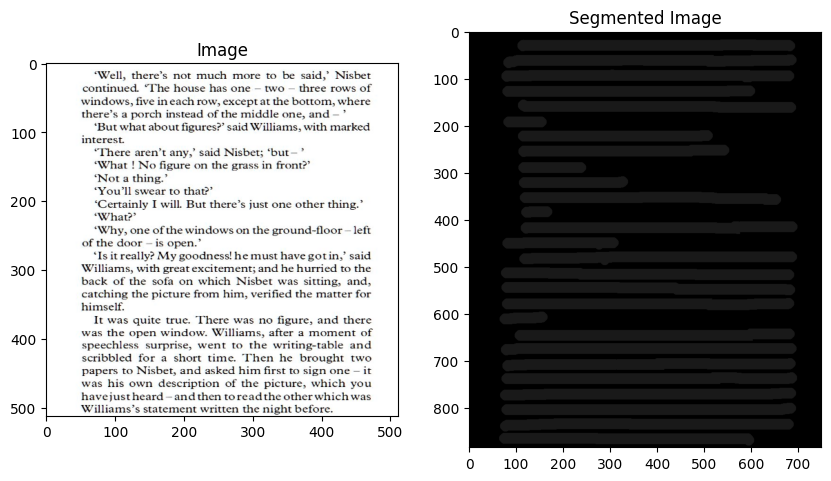

In [2]:

img=cv2.imread('Datasets/PageSegData/PageImg/'+image_list[1]+'.JPG',1)
seg=cv2.imread('Datasets/PageSegData/PageSeg/'+image_list[1]+'_mask.png',1)
img = np.squeeze(img)
img=cv2.resize(img,(512,512))
print(img.shape)

visualize(img,seg)

In [4]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)
    return model


model=unet()

c:\Users\Admin\Documents\BE 5\Project Python\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


c:\Users\Admin\Documents\BE 5\Project Python\venv\lib\site-packages\ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


: 

: 